# Modeling Sensor Readings
I have constructed 
* `Visualize_Senosr_Reading.py`
* `humidityTempSensor.ino`
* `arduino.yml`

to gather and record humidity sensor readings. In this notebook, I will fit the experimental data to a model I designed using a **Linear First Order Differential Equation**.

## Model description
I made `Visualize_Sensor_Reading.ipynb` as my first attempt to model humidity, but the documentation and implementations where slightly lacking. I decided to re-do it.

**Concept**<br>
To build a mathematical description of my system I first needed to imagine a model of evaporation. I decided to model this process as a simple 1-D line of points, where some proportion of points on this line would lift up, and some proportion of lifted points would settle back down. The key question in this model would be *How many atoms are on the line at time t?*.

**Molecules on line at time 0 and at time $\Delta t$**<br>
Lets first define some variables:<br>
* $n_l$ = Number of molecules on the line [molecules].
* $n_a$ = Number of molecules in the air [molecules].
* $n_{l0}$ = Intial number of molecules observed on the line [molecules].
* $t$ = Some time of observation [t].
* $\Delta t$ = Difference between first observation and second [t].
* $U$ = The proportion of molecules that lift **U**p from the line per unit time [$t^{-1}$].
* $D$ = The proportion of molecules that return back **D**own to the line per unit time [$t^{-1}$].

Having defined the variables above, we can make the following statement<br>
At some initial time t, we observe that there are $n_{l0}$ molecules on the line $$F(t) \equiv n_l(t) = n_{l0}$$
After some $\Delta t$ (1 second, 2 seconds, 0.1 seconds) we look back and see that some molecules lifted up, but some returned according to the following equation $$F(t) \equiv n_l(t + \Delta t) = n_{l0} + Dn_A \Delta t - Un_L \Delta t$$
The goal here is to generate a derivative and estimate the rate of change for $n_l(t)$. We can achieve this by remembering  the definition of a derivative and squishing our formula into that form $$\frac{dn_l}{dt} = \lim_{\Delta t \to 0} \frac{n_l(t+\Delta t) - n(t)}{\Delta t} = \frac{ (n_{l0} + Dn_A \Delta t - Un_L \Delta t) -  (n_{l0})}{\Delta t} = \frac{\Delta t (Dn_A - Un_L)}{\Delta t} = Dn_A - Un_L$$
As we can see, the rate of change is purely dependant on the proportions of molecules in the air coming down and the proportion of molecules on the line lifting up. This is recognizably in the form of a linear ODE, so lets make that explicit.

**First order linear ODE form**<br>
Rearranging the terms gives us 
$$\frac{dn_l}{dt} + Un_l = Dn_a$$
Unfortunately, I don't know how to take a derivative or integral of $n_a$, so lets make another simplifying assumption that the system we are dealing with is closed. Therefore $n_l + n_a = n_{total}$, were 
* $n_{total}$ is some constant number of molecules. [molecules]

Now we have a nice way to transform $n_a$ into $n_l$. Pluggin this relationship in we get 
$$\frac{dn_l}{dt} + (U+D)n_l = Dn_{total}$$

**Solving the first order ODE**<br>
1. Write out the solution form and values to solve for
    1. $\mu (t) = e^{\int_{t_0}^t p(t)\,dt}$, here $p(t)$ is (U+D)
    1. $n_l(t) = \frac{1}{\mu (t)}  \Bigg ( n_{l0} + \int_{t_0}^t \mu (t)\,g(t)dt \Bigg )$, here $g(t)$ is $Dn_{total}$
1. Solving for $\mu (t)$ and just summarizing the constant terms as a new variable 'a'<br>
$\mu (t) = ae^{(U+D)t}$<br>
$a = e^{-(U-D)t_0}$
1. Plug $\mu (t)$ and $g(t)$ then solve (this is pretty annoying and time consuming, good luck, don't get lost)
1. Answer 
$$n_l(t) = n_{l0}e^{-(U+D)t} + \frac{Dn_{total}}{U+D}\Bigg ( 1 - e^{-(U+D)t}\Bigg )$$
1. $\frac{Dn_{total}}{U+D}$ this is the equilibrium to equation is working towards.
1. To solve for relative humidity, divide the entire formula by $n_total$
1. Check to make sure that at $t = t_0 = 0$ that the formula produces $n_{l0}$. It does.

## Diff eq summary
$$n_l(t) = n_{l0}e^{-(U+D)t} + \frac{Dn_{total}}{U+D}\Bigg ( 1 - e^{-(U+D)t}\Bigg )$$

* $n_l$ = Number of molecules on the line [molecules].
* $n_a$ = Number of molecules in the air [molecules].
* $n_{l0}$ = Intial number of molecules observed on the line [molecules].
* $n_{total}$ is some constant number of molecules. [molecules]
* $t$ = Some time of observation [t].
* $\Delta t$ = Difference between first observation and second [t].
* $U$ = The proportion of molecules that lift **U**p from the line per unit time [$t^{-1}$].
* $D$ = The proportion of molecules that return back **D**own to the line per unit time [$t^{-1}$].

In [1]:
# live_plot_sensor.py
import time
from datetime import date
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from math import e
# https://realpython.com/linear-regression-in-python/
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
# https://education.molssi.org/python-data-analysis/03-data-fitting/index.html
from scipy.optimize import curve_fit


def rollingFun(data, windowSize, fun=np.mean):
    rollingAverage = []
    data = np.array(data)
    for i in range(len(data)):
        windowStart = np.maximum(0,i-windowSize)
        windowEnd = np.minimum(len(data)-1,i+windowSize)
        rollingAverage.append(fun(data[windowStart:windowEnd]))
    return(rollingAverage)

In [2]:
df = pd.read_csv("../../../BME51/self_projects/incubator/humidityTempSensor/temp_humidity_11_16_22_airtight.txt")

In [3]:
x = np.array(range(1,len(df['Humidity'])+1))
x = x.reshape(-1,1)
yH = df['Humidity']
yT = rollingFun(df['Temp'], 200)

Plotting the raw collected data looks like the following

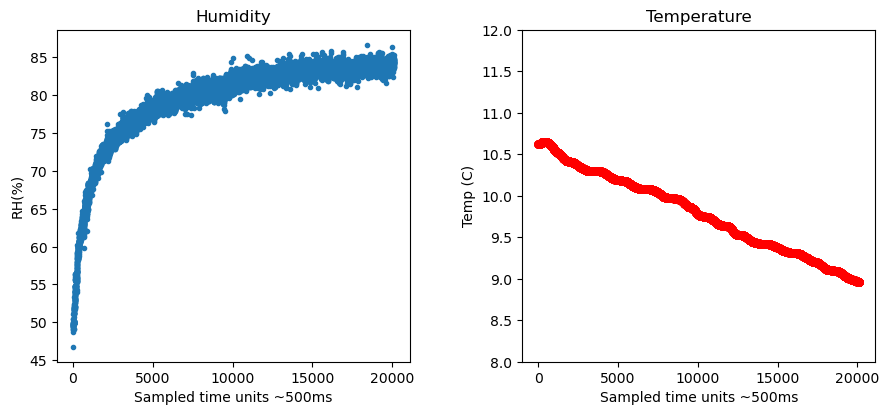

In [4]:
fig, ax = plt.subplots(1,2, figsize=[10,5])
fig.tight_layout(pad=5.0)
ax[0].title.set_text("Humidity")
ax[0].set_ylabel('RH(%)')
ax[0].plot(x,yH, linewidth=0, marker='.')
ax[1].title.set_text("Temperature")
ax[1].set_ylabel('Temp (C)')
ax[1].set_ylim([8,12])
ax[1].scatter(x,yT, linewidth=0, c='red')

for axs in ax:
    axs.set_xlabel("Sampled time units ~500ms")

# Fitting the data to my model
Following the tutorial found here https://education.molssi.org/python-data-analysis/03-data-fitting/index.html
, I will now fit my model to the data using the following steps. **Note** The `curve_fit` function may not like very big numbers, or it may require initial guesses to converge. Try either giving it guesses or divide your input x's to make them smaller.
1. Define my equation
1. Define my data
1. fit the curve
1. plot the fit and the original data

## Defining my 1st order model

In [16]:

def nv(t, ni, U, D):
    return(ni*e**(-(U+D)*t) + ((D)/(U+D)) * (1-e**(-(U+D)*t)))
def nspan(numbers):
    return([np.min(numbers), np.max(numbers)])

## Defining my data

In [7]:
df = pd.read_csv("../../../BME51/self_projects/incubator/humidityTempSensor/temp_humidity_11_16_22_airtight.txt")
df['Time'] = pd.to_datetime(df['Time'])
x = np.array(range(1,(len(df['Humidity'])+1)))/2/60
yH = df['Humidity']/100

## Fitting the curve

In [11]:
parameters, covariance = curve_fit(nv, x, yH)
SE = np.sqrt(np.diag(covariance))

In [26]:
fit_ni = parameters[0]; SE_ni = SE[0]
fit_U = parameters[1]; SE_U = SE[1] # <- secretly down
fit_D = parameters[2]; SE_D = SE[2] # <- secretly up
fit_yH = nv(x, fit_ni, fit_U, fit_D)
print(f'Curve fitting results:\nni: {fit_ni} -- SE: {SE_ni}\nU: {fit_U} -- SE: {SE_U}\nD: {fit_D} -- SE: {SE_D}')

Curve fitting results:
ni: 0.5790365373577722 -- SE: 0.000512073132234915
U: 0.007437131556231602 -- SE: 3.004130824201466e-05
D: 0.03623313717636486 -- SE: 0.00012369819013933594


Saturation occurs at 0.8296980583799256


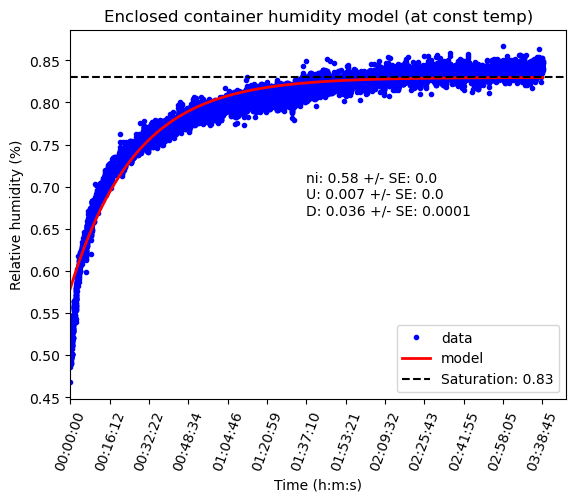

In [23]:
plt.title("Enclosed container humidity model (at const temp)")
plt.plot(x,yH, marker='.', linewidth=0, c='blue', label='data')
plt.plot(x,fit_yH, linewidth=2, c='red', label='model')
plt.axhline(fit_D/(fit_U+fit_D), c='black', label=f'Saturation: {round(fit_D/(fit_U+fit_D), 3)}', linestyle='--')
plt.xlim(left=min(x))
plt.legend(loc='lower right')
plt.ylabel("Relative humidity (%)")
plt.xlabel('Time (h:m:s)')
# np.linspace(0,max(x), 10)
plot_labels = (df.Time - df.Time[0]).astype(str).str.replace('0 days ', '')# np.round_(x,2) # df.Time.dt.time #
plt.xticks([x[i] for i in range(0,len(x),len(x)//12)], labels=plot_labels[range(0,len(x),len(x)//12)], rotation=70)
plt.text(x=np.mean(x),y=np.mean(nspan(yH)),s=f'ni: {round(fit_ni,2)} +/- SE: {round(SE_ni,2)}\nU: {round(fit_U,3)} +/- SE: {round(SE_U,3)}\nD: {round(fit_D,3)} +/- SE: {round(SE_D,4)}')
print(f'Saturation occurs at {fit_D/(fit_U+fit_D)}')
plt.show()

# Conclusions
I messed up just a tad, I started modeling by considering my system from the point of view of the molecules down on the line when I should've considered the molecules that are up in the air. For my system I would just subtract from $n_{total}$, but that is still quite embarrasing. 

That being said, this setup of the problem is much nicer than my last attempt. Although they produce virtually the same result, I believe this is a much more interpretable solution.

It seems to indicate that in my system 0.7% of molecules are returning back to the dish, while 3.6% of molecules in the dish are rising up into the air. I think that makes sense because if we had an equal rise and fall rate, then our saturation would be at 50% humidity. I think that these numbers may reflect reality, because an 1/5 proportion would produce the same saturation rate, but the bend of the graph would change. 

My fit isn't perfect unfortunately. My assumption of constant temperature was violated as shown in the first graph. We have a subtle temperature change from 10 degrees celcius to 9 degrees, and I believe if we can model that the curve would properly account for the sharper elbow of the data.